<a href="https://colab.research.google.com/github/shinysong/Text-Mining/blob/main/%EA%B3%B5%EA%B3%B5%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_%EC%86%A1%EC%B1%84%EC%9D%80_20164051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

공공데이터포털의 공공데이터 메타데이터를 이용하여 2가지 작업을 할 것이다.  

1. 공공데이터포털의 각 데이터를 크롤링한 
후, 지방자치단체별로 나눈다.
지방자치단체별로 데이터 상세설명을 통해 토픽모델링을 진행하고자 한다.

2. word2vec을 이용하여 공공데이터 파일명과 키워드를 이용한 연관데이터 추천시스템을 구현한다.

# 1. 공공데이터 지자체별 토픽모델링

## 데이터 전처리

In [ ]:
!pip install konlpy

In [ ]:
!pip install pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import * 
from gensim import corpora, models
import gensim
import pyLDAvis
import pyLDAvis.gensim
%matplotlib nbagg

In [ ]:
df = pd.read_excel("200915 공공데이터.xlsx")

In [ ]:
df.columns

Index(['URL', 'pre_type', 'category_brown', 'category_red', 'pre_title',
       'extend', 'file_name', 'category', 'provider', 'MDname', 'MDnumber',
       'basis_retention', 'collection_method', 'update_cycle', 'next_update',
       'media_type', 'full_row', 'view', 'download', 'period_data',
       'data_limit', 'keyword', 'registration_date', 'modification_date',
       'provision', 'pro_url', 'description', 'etc', 'cost_status',
       'cost_unit', 'scope', 'download_YN'],
      dtype='object')

### 결측치제거

In [ ]:
df2 = df[['category_red','pre_title','provider','description']].dropna()

In [ ]:
df2

,category_red,pre_title,provider,description
0,공공기관,정보통신정책연구원_영상보고서,정보통신정책연구원,"정보통신정책연구원 발행 영상보고서(번호, 동영상명, 발표자, 등록일, 유튜브 바로가기)"
1,공공기관,한국나노기술원_대관 예약신청 현황,한국나노기술원,한국나노기술원(경기/수원) 대관시설 및 예약 현황 - 프리젠테이션룸(1F)빔프로젝터...
2,자치행정기관,경기도_오산시_문자발송시스템(UMS) 사용내역,경기도 오산시,오산시 UMS문자발송시스템 사용내역 입니다.
3,자치행정기관,경기도_오산시_문자발송시스템(UMS) 코드 현황,경기도 오산시,"문자발송시스템 코드, 코드분류, 코드이름 코드 현황 정보입니다."
4,자치행정기관,경기도_오산시_문자발송시스템(UMS) 부서별 건수,경기도 오산시,"문자발송시스템 부서이름, 부서SMS/LMS/MMS건수, SMS/LMS/MMS사용여부..."
...,...,...,...,...
33724,자치행정기관,약수터 수질검사결과,인천광역시 보건환경연구원,약수터 수질검사결과
33725,자치행정기관,대기평균 측정데이터,인천광역시 보건환경연구원,대기평균 측정데이터
33726,자치행정기관,2013 VOC광화학오염물질오염도 측정결과,인천광역시 보건환경연구원,2013 VOC광화학오염물질오염도 측정결과
33727,자치행정기관,지방하수도수질검사결과,전라남도 나주시,지방하수도수질검사결과


### 지방자치기관 그룹핑

In [ ]:
df3 = df2[df2['category_red'] == '자치행정기관']
df3

,category_red,pre_title,provider,description
2,자치행정기관,경기도_오산시_문자발송시스템(UMS) 사용내역,경기도 오산시,오산시 UMS문자발송시스템 사용내역 입니다.
3,자치행정기관,경기도_오산시_문자발송시스템(UMS) 코드 현황,경기도 오산시,"문자발송시스템 코드, 코드분류, 코드이름 코드 현황 정보입니다."
4,자치행정기관,경기도_오산시_문자발송시스템(UMS) 부서별 건수,경기도 오산시,"문자발송시스템 부서이름, 부서SMS/LMS/MMS건수, SMS/LMS/MMS사용여부..."
10,자치행정기관,충청북도_진천군_태양광발전소 현황,충청북도 진천군,"진천군별로 발전소명, 설치장소, 설비용량, 허가일자, 사업개시일을 보여줌."
16,자치행정기관,인천광역시 남동구_다중이용시설 현황,인천광역시 남동구,다중이용시설 현황
...,...,...,...,...
33724,자치행정기관,약수터 수질검사결과,인천광역시 보건환경연구원,약수터 수질검사결과
33725,자치행정기관,대기평균 측정데이터,인천광역시 보건환경연구원,대기평균 측정데이터
33726,자치행정기관,2013 VOC광화학오염물질오염도 측정결과,인천광역시 보건환경연구원,2013 VOC광화학오염물질오염도 측정결과
33727,자치행정기관,지방하수도수질검사결과,전라남도 나주시,지방하수도수질검사결과


In [ ]:
# split(): 구분자를 기준으로 n개로 나눈다, expand=True이면 여러 컬럼, False이면 1개 컬럼에 리스트
df3['local'] = df3['provider'].str.split(' ').str[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df3

,category_red,pre_title,provider,description,local
2,자치행정기관,경기도_오산시_문자발송시스템(UMS) 사용내역,경기도 오산시,오산시 UMS문자발송시스템 사용내역 입니다.,경기도
3,자치행정기관,경기도_오산시_문자발송시스템(UMS) 코드 현황,경기도 오산시,"문자발송시스템 코드, 코드분류, 코드이름 코드 현황 정보입니다.",경기도
4,자치행정기관,경기도_오산시_문자발송시스템(UMS) 부서별 건수,경기도 오산시,"문자발송시스템 부서이름, 부서SMS/LMS/MMS건수, SMS/LMS/MMS사용여부...",경기도
10,자치행정기관,충청북도_진천군_태양광발전소 현황,충청북도 진천군,"진천군별로 발전소명, 설치장소, 설비용량, 허가일자, 사업개시일을 보여줌.",충청북도
16,자치행정기관,인천광역시 남동구_다중이용시설 현황,인천광역시 남동구,다중이용시설 현황,인천광역시
...,...,...,...,...,...
33724,자치행정기관,약수터 수질검사결과,인천광역시 보건환경연구원,약수터 수질검사결과,인천광역시
33725,자치행정기관,대기평균 측정데이터,인천광역시 보건환경연구원,대기평균 측정데이터,인천광역시
33726,자치행정기관,2013 VOC광화학오염물질오염도 측정결과,인천광역시 보건환경연구원,2013 VOC광화학오염물질오염도 측정결과,인천광역시
33727,자치행정기관,지방하수도수질검사결과,전라남도 나주시,지방하수도수질검사결과,전라남도


In [ ]:
df3.groupby('local').count()

,category_red,pre_title,provider,description
local,,,,
강원도,450,450,450,450
경기도,2124,2124,2124,2124
경상남도,1157,1157,1157,1157
경상북도,827,827,827,827
광주광역시,794,794,794,794
대구광역시,598,598,598,598
대전광역시,379,379,379,379
부산광역시,1802,1802,1802,1802
서울특별시,2980,2980,2980,2980


In [ ]:
강원_raw = df3[df3['local']=='강원도']
경기_raw = df3[df3['local']=='경기도']
경남_raw = df3[df3['local']=='경상남도']
경북_raw = df3[df3['local']=='경상북도']
광주_raw = df3[df3['local']=='광주광역시']
대구_raw = df3[df3['local']=='대구광역시']
대전_raw = df3[df3['local']=='대전광역시']
부산_raw = df3[df3['local']=='부산광역시']
서울_raw = df3[df3['local']=='서울특별시']
세종_raw = df3[df3['local']=='세종특별자치시']
울산_raw = df3[df3['local']=='울산광역시']
인천_raw = df3[df3['local']=='인천광역시']
전남_raw = df3[df3['local']=='전라남도']
전북_raw = df3[df3['local']=='전라북도']
제주_raw = df3[df3['local']=='제주특별자치도']
충남_raw = df3[df3['local']=='충청남도']
충북_raw = df3[df3['local']=='충청북도']

### 텍스트 변환 및 전처리 함수

In [ ]:
stop_word = '\n \t ( ) / ~ * < KW - _ . , 시스템 계 폐 액 길 관련 군 관 구 축 욕 율 률 데이터 대구광역시 특별자치도 서울 세종 제주 일반 광역시 관내 특별시 자치시 자치도 통계 일자 자료 허가 등록 사업 업체 년도 기준 설치 그 이 농 읍 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 \
현황 정보 시설 제공 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 층 소 \
 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 \
설명 소명 초 소 량 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 \
번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 소리 놓 임 업 별 년월 령 물 용 \
항 간 건만 이번 후 여 토 야 호 를 을 거 석 학 위 세 로서 규 민 며 또한 률 고 라며 크게 회 권 장 의 인 산 은 사 스 거나 은 로 및 여기 차 실 기 팀 앤 어 시스 비 제 국 곳 가의 드 만 비 ' #따로 추가한 부분

In [ ]:
def LocalTopic(DataFrame, stop_word, str, str2 = '시', str3 = '읍'):
  #각 파일의 설명 합치기
  local_set = []
  for i in DataFrame['description']:
    local_set.append(i)
  #불용어 제거
  terms = []
  stopword_list = stop_word.split(' ')
  stopword_list.append(str)
  stopword_list.append(str2)
  stopword_list.append(str3)
  #토크나이징
  for w in local_set:
    okt = Okt()
    tokens = okt.nouns(w)
    stop_tokens = [i for i in tokens if not i in stopword_list] # 스탑워드가 아닌거만 넣어라
    terms.append(stop_tokens)
  #training vocabulary
  dictionary = corpora.Dictionary(terms)
  # 문서-단어 행렬(document-term matrix) 생성
  corpus = [dictionary.doc2bow(term) for term in terms]
  #tfidf document-term matrix 
  tfidf = models.TfidfModel(corpus)
  corpus_tfidf = tfidf[corpus]

  #LDA 분석
  NUM_TOPICS = 7
  model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word = dictionary)
  word_dict = {}
  for i in range(NUM_TOPICS):
    words = model.show_topic(i, topn=20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    word_df = pd.DataFrame(word_dict)

  #시각화
  pyLDAvis.enable_notebook()
  data_graph = pyLDAvis.gensim.prepare(model, corpus, dictionary)

  return word_df, data_graph

## 지방자치단체별 토픽모델링 결과

### 강원도

In [ ]:
강원_data, 강원_gragh = LocalTopic(강원_raw, stop_word, '강원도')

In [ ]:
강원_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,원주시,주소,주소,소재지,소재지,전화번호,주소
1,소재지,전화번호,연락처,전화번호,위도,주소,소재지
2,강릉시,동해시,채취,위치,경도,위치,강릉시
3,마을,원주시,상호,단지,연락처,원주시,연락처
4,주소,연락처,삼척시,연락처,도로명주소,폐기물,전화번호
5,전화번호,음식점,면적,신고,위치,소재지,음식점
6,대수,위치,소재지,동해시,원주시,의료,면적
7,지정,신고,골재,산업,산업,배출,동해시
8,위치,용도,위치,인구,전화번호,춘천시,사무소
9,명칭,관리,강릉시,가격,지정,공장,삼척시


In [ ]:
강원_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.026077 -0.027629       1        1  18.303946
4     -0.067974  0.070282       2        1  15.229210
5      0.155564  0.059567       3        1  14.358791
3     -0.041534  0.080411       4        1  14.173567
0     -0.068796  0.010071       5        1  14.064960
2      0.003211 -0.102239       6        1  13.753793
1     -0.006548 -0.090462       7        1  10.115732, topic_info=     Term       Freq      Total Category  logprob  loglift
18     주소  71.000000  71.000000  Default  30.0000  30.0000
415    채취  15.000000  15.000000  Default  29.0000  29.0000
625    의료   9.000000   9.000000  Default  28.0000  28.0000
128    면적  14.000000  14.000000  Default  27.0000  27.0000
795    배출  13.000000  13.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
14    소재지   1.508690  71.034644   Topic7  -5.2739  -1.5608
80     위도   1.504731  19.763940   Topic7  -5.2766  -0.2842
810  수질검사   1.504585   6.760550   Topic7  -5.2767   0.7885
33     산업   1.504432  17.324858   Topic7  -5.2768  -0.1526
77     경도   1.504209  19.763037   Topic7  -5.2769  -0.2845

[477 rows x 6 columns], token_table=      Topic      Freq Term
term                      
177       1  0.249681   가격
177       2  0.124840   가격
177       4  0.312101   가격
177       5  0.124840   가격
177       6  0.124840   가격
...     ...       ...  ...
180       5  0.655228   회관
681       3  0.837071   회사
267       2  0.815568   횡성
401       7  0.679208   후문
590       2  0.620569   후원

[753 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 6, 4, 1, 3, 2])

### 경기도

In [ ]:
경기_data, 경기_gragh = LocalTopic(경기_raw, stop_word, '경기도')

In [ ]:
경기_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,석면,수질검사,용량,규격,폐기물,상수도,주소
1,건축물,수집,배출,측정,배출,검사,처리
2,보급,환경오염,소재지,위치,소재지,요금,위치
3,가로수,약수터,상수도,청소,전화번호,전화번호,코드
4,조사,발생,업종,이름,주소,관측,소재지
5,대한,결과,환경오염,정화조,수거,업종,구분
6,안양시,소재지,위치,개장,상호,주소,안산시
7,수종,압력,군포시,유량,구분,수도,배출
8,강수량,물질,상호,품목,대형,처리,관리
9,측정값,구리시,주소,저장,관리,대행,고양시


In [ ]:
경기_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.080558  0.047140       1        1  26.315472
4      0.178372 -0.077510       2        1  16.676364
1     -0.042145 -0.034735       3        1  13.055155
3     -0.030221 -0.129740       4        1  12.426343
5      0.017730  0.170060       5        1  10.883744
0     -0.206617 -0.007517       6        1  10.697434
2      0.002322  0.032301       7        1   9.945488, topic_info=      Term        Freq       Total Category  logprob  loglift
585     배출  290.000000  290.000000  Default  30.0000  30.0000
1371  수질검사  110.000000  110.000000  Default  29.0000  29.0000
618    폐기물  236.000000  236.000000  Default  28.0000  28.0000
1133    용량  120.000000  120.000000  Default  27.0000  27.0000
2246    석면   81.000000   81.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
34    전화번호   19.383400  217.743135   Topic7  -4.4633  -0.1108
1319    물질   13.020737   51.973906   Topic7  -4.8612   0.9239
112     종류   12.366386   46.764114   Topic7  -4.9127   0.9779
300     처리   13.893789  197.333335   Topic7  -4.7963  -0.3454
608    안양시   12.806141   99.387727   Topic7  -4.8778   0.2589

[412 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
360       4  0.663038    가구
2286      6  0.842753   가로수
2286      7  0.140459   가로수
874       1  0.056933    가스
874       2  0.113865    가스
...     ...       ...   ...
2211      7  0.330852  환경오염
1490      1  0.253780    회관
1490      4  0.507560    회관
695       2  0.251220    횟수
695       4  0.711791    횟수

[939 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 2, 4, 6, 1, 3])

### 경상남도

In [ ]:
경남_data, 경남_gragh = LocalTopic(경남_raw, stop_word, '경상남도')

In [ ]:
경남_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,주소,주소,김해시,주소,경남,주소,주소
1,경남,지정,주소,전화번호,대한,소재지,창원시
2,번호,연락처,면적,소재지,관리,김해시,연락처
3,소재지,경남,상호,기관,기관,경남,김해시
4,전화번호,창녕군,개별,김해시,위치,연락처,처리
5,창원시,업종,위치,대표자,김해시,구분,번호
6,거창군,김해시,함안군,연락처,소재지,배출,가격
7,연락처,대회,전화번호,폐기물,주소,전화번호,처방
8,역,전화번호,공시지가,진주시,면적,면적,경남
9,대한,소재지,판매,의료,창원시,인구,대표자


In [ ]:
경남_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.073790  0.007313       1        1  22.156210
1      0.101777  0.014926       2        1  16.931385
5     -0.070559 -0.014960       3        1  16.298097
4     -0.087146 -0.058460       4        1  12.631020
2     -0.007588  0.138099       5        1  11.804245
0      0.077267 -0.050110       6        1  10.399353
6      0.060039 -0.036809       7        1   9.779691, topic_info=     Term       Freq       Total Category  logprob  loglift
1023   대회  14.000000   14.000000  Default  30.0000  30.0000
27     처리  22.000000   22.000000  Default  29.0000  29.0000
481    개별  22.000000   22.000000  Default  28.0000  28.0000
333   함안군  23.000000   23.000000  Default  27.0000  27.0000
325    가격  21.000000   21.000000  Default  26.0000  26.0000
...   ...        ...         ...      ...      ...      ...
167   소재지   5.218272  105.790504   Topic7  -4.9314  -0.6844
461   밀양시   3.267260   26.480820   Topic7  -5.3996   0.2324
6     거창군   3.265884   29.402461   Topic7  -5.4000   0.1273
319    상호   3.267620   42.198945   Topic7  -5.3995  -0.2335
25     위치   3.267619   49.098403   Topic7  -5.3995  -0.3849

[510 rows x 6 columns], token_table=      Topic      Freq Term
term                      
325       2  0.375491   가격
325       5  0.187745   가격
325       6  0.093873   가격
325       7  0.281618   가격
169       2  0.588942   가능
...     ...       ...  ...
304       4  0.253851   회사
304       5  0.152311   회사
304       6  0.050770   회사
304       7  0.101541   회사
801       7  0.833305   횟수

[987 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 6, 5, 3, 1, 7])

### 경상북도

In [ ]:
경북_data, 경북_gragh = LocalTopic(경북_raw, stop_word, '경상북도')

In [ ]:
경북_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,주소,구미시,전화번호,주소,계약,주소,관리
1,전화번호,주소,소재지,발전소,주소,연락처,주소
2,판매,전화번호,주소,소재지,소재지,소재지,전화번호
3,어린이집,소재지,기관,영주시,연락처,위치,지정
4,연락처,상호,번호,구미시,상호,면적,마을
5,대표자,버스,구미시,용량,전화번호,인구,경주시
6,가격,테이블,업종,칠곡군,김천시,명칭,구미시
7,유통,공사,위치,복지,신고,영주시,위치
8,발전소,교육,관리,고령군,구미시,채취,배출
9,구미시,면적,면적,연락처,포항시,상호,홈페이지


In [ ]:
경북_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.010160 -0.068768       1        1  17.590469
6     -0.084478 -0.074631       2        1  17.345943
5     -0.024703  0.110885       3        1  15.136981
1     -0.021326  0.021610       4        1  13.280849
4     -0.068036  0.010171       5        1  12.767735
3      0.078975  0.058954       6        1  12.651828
0      0.109408 -0.058221       7        1  11.226195, topic_info=     Term       Freq      Total Category  logprob  loglift
20     계약  28.000000  28.000000  Default  30.0000  30.0000
8     발전소  22.000000  22.000000  Default  29.0000  29.0000
128    관리  48.000000  48.000000  Default  28.0000  28.0000
18   전화번호  95.000000  95.000000  Default  27.0000  27.0000
639    공사  13.000000  13.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
364    위치   3.189520  57.486677   Topic7  -5.2878  -0.7048
46    포항시   3.187519  39.798619   Topic7  -5.2885  -0.3377
303    처리   3.186805  20.279730   Topic7  -5.2887   0.3363
25    영양군   3.186791  17.078991   Topic7  -5.2887   0.5081
105   영천시   3.186324  16.901781   Topic7  -5.2888   0.5184

[489 rows x 6 columns], token_table=      Topic      Freq Term
term                      
117       1  0.252850   가격
117       2  0.126425   가격
117       4  0.252850   가격
117       7  0.379276   가격
690       3  0.120415  가금류
...     ...       ...  ...
332       4  0.080588   회사
332       5  0.080588   회사
332       7  0.241764   회사
375       3  0.802111   회의
404       7  0.631214   횟수

[901 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 2, 5, 4, 1])

### 광주광역시

In [ ]:
광주_data, 광주_gragh = LocalTopic(광주_raw, stop_word, '광주')

In [ ]:
광주_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,서구,주소,소방,위치,소방,소재지,주소
1,대한,기관,주소,주소,소재지,위치,광산구
2,위치,광산구,대상,운영,동구,센터,위치
3,소방,소방,기관,실적,대상,전화번호,전화번호
4,지역,이용,도로,지역,위치,주소,운영
5,광산구,출동,인원,동구,지역,광산구,면적
6,주소,운영,건수,검사,전화번호,북구,지정
7,관리,위치,대표자,지원,지원,관리,동구
8,명칭,남구,학교,센터,주소,기관,판매
9,안전,관리,활동,폐기물,광산구,업종,의안


In [ ]:
광주_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.060558 -0.005803       1        1  16.219716
0      0.033161 -0.095285       2        1  15.922184
4      0.037281 -0.021702       3        1  15.583839
3     -0.059790 -0.052334       4        1  14.202242
5     -0.069311  0.016537       5        1  13.204022
2      0.106571  0.090863       6        1  12.635447
6     -0.108471  0.067723       7        1  12.232550, topic_info=    Term       Freq      Total Category  logprob  loglift
0     서구  55.000000  55.000000  Default  30.0000  30.0000
15    소방  88.000000  88.000000  Default  29.0000  29.0000
10    대한  38.000000  38.000000  Default  28.0000  28.0000
156   대상  40.000000  40.000000  Default  27.0000  27.0000
90   소재지  44.000000  44.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
8     지역   4.400977  47.741238   Topic7  -5.0499  -0.2829
467   학교   3.436673  22.484144   Topic7  -5.2973   0.2228
193   구별   3.435909  22.995664   Topic7  -5.2975   0.2000
28    광산   3.437527  24.601280   Topic7  -5.2970   0.1330
90   소재지   3.308137  44.147792   Topic7  -5.3354  -0.4901

[493 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1417      7  0.815783   가압
102       1  0.427862   가축
102       2  0.142621   가축
102       4  0.142621   가축
102       5  0.142621   가축
...     ...       ...  ...
80        2  0.286884   활동
80        3  0.172130   활동
80        5  0.114754   활동
80        6  0.286884   활동
80        7  0.057377   활동

[917 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 4, 6, 3, 7])

### 대구광역시

In [ ]:
대구_data, 대구_gragh = LocalTopic(대구_raw, stop_word, '대구')

In [ ]:
대구_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,식품,주소,위치,중구,소재지,주소,주소
1,주소,전화번호,전화번호,달서구,주소,전화번호,건축
2,안내,소재지,서구,목록,전화번호,동구,위치
3,관리,상호,소재지,서구,업종,소재지,북구
4,판매업,위치,대구시,도서,수성구,분야,펌프
5,북구,북구,중구,주소,연락처,연보,규모
6,지정,연락처,안내,대구시,북구,달서구,달서구
7,교육,폐기물,북구,연보,위치,연락처,전화번호
8,기관,신고,관리,노선,단속,지정,지역
9,운영,관리,음식점,계약,지역,인구,유형


In [ ]:
대구_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.105523  0.034340       1        1  19.029638
1      0.074292 -0.005293       2        1  16.752152
5      0.014375  0.037857       3        1  15.196081
6      0.035956 -0.144225       4        1  14.152076
0     -0.031850  0.096032       5        1  13.126205
2     -0.046471  0.015464       6        1  12.090403
3     -0.151824 -0.034174       7        1   9.653445, topic_info=     Term       Freq      Total Category  logprob  loglift
112    업종  24.000000  24.000000  Default  30.0000  30.0000
164   소재지  73.000000  73.000000  Default  29.0000  29.0000
334    중구  29.000000  29.000000  Default  28.0000  28.0000
311    식품  21.000000  21.000000  Default  27.0000  27.0000
280    상호  31.000000  31.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
9      유형   2.339362  18.794564   Topic7  -5.1168   0.2542
332    동향   1.832520   5.670233   Topic7  -5.3609   1.2083
282   수성구   2.340998  33.164977   Topic7  -5.1161  -0.3131
145    위치   2.342652  60.998005   Topic7  -5.1154  -0.9217
0    전화번호   2.343998  79.357618   Topic7  -5.1148  -1.1843

[479 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
160       1  0.537735    가격
160       5  0.134434    가격
160       6  0.268868    가격
1014      3  0.611491    가로
168       1  0.198659    가맹
...     ...       ...   ...
485       3  0.807728    회사
485       7  0.134621    회사
471       6  0.876880  횡단보도
184       2  0.521170    휴게
184       6  0.260585    휴게

[812 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 6, 7, 1, 3, 4])

### 대전광역시

In [ ]:
대전_data, 대전_gragh = LocalTopic(대전_raw, stop_word, '대전광역시')

In [ ]:
대전_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,주소,가격,전화번호,소재지,도서,대출,장비
1,서구,서구,주소,전화번호,대덕구,도서,유성구
2,영업,노인,의료,주소,계약,도서관,소재지
3,대전,동향,기관,중구,주소,실적,규모
4,상태,주소,서구,서구,출판사,저자,병원
5,참여,소재지,동구,대덕구,저자,출판,급수
6,가정우,대덕구,유성구,복지,유성구,출판사,상수도
7,자녀,센터,소재지,상호,전화번호,선,동구
8,교육,개인,대덕구,연락처,도서관,선정,배출
9,대한,대수,명칭,장애인,번호,베스트,상호


In [ ]:
대전_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.109537 -0.060578       1        1  20.119087
2      0.098032 -0.104396       2        1  19.577380
0      0.065924  0.143643       3        1  16.931075
4     -0.104500 -0.079488       4        1  14.107089
1     -0.000546  0.016034       5        1  10.929764
5     -0.189664  0.012787       6        1   9.421760
6      0.021217  0.071997       7        1   8.913845, topic_info=     Term       Freq      Total Category  logprob  loglift
179    대출  12.000000  12.000000  Default  30.0000  30.0000
157    도서  20.000000  20.000000  Default  29.0000  29.0000
359    의료  18.000000  18.000000  Default  28.0000  28.0000
158   도서관  11.000000  11.000000  Default  27.0000  27.0000
110    기관  20.000000  20.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
6      상태   1.564766  14.825362   Topic7  -4.8135   0.1690
25     중구   1.565657  22.628013   Topic7  -4.8129  -0.2533
31     서구   1.566951  45.740431   Topic7  -4.8121  -0.9563
9    전화번호   1.569108  53.108961   Topic7  -4.8107  -1.1043
24     주소   1.567227  56.405419   Topic7  -4.8119  -1.1657

[425 rows x 6 columns], token_table=      Topic      Freq Term
term                      
59        1  0.094262   가격
59        2  0.282785   가격
59        4  0.094262   가격
59        5  0.565569   가격
496       6  0.707137   가맹
...     ...       ...  ...
71        6  0.346158   활동
609       6  0.480969   회계
126       2  0.858221   회관
50        5  0.737106   회의
185       6  0.736180   횟수

[619 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2, 6, 7])

### 부산광역시

In [ ]:
부산_data, 부산_gragh = LocalTopic(부산_raw, stop_word, '부산광역시')

In [ ]:
부산_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,주소,전화번호,주소,소재지,소재지,위치,기관
1,위치,주소,소재지,전화번호,남구,주소,의료
2,연락처,소재지,사상구,주소,전화번호,연제구,해운대구
3,면적,기관,교육,업종,위치,동래구,관리
4,전화번호,기장군,명칭,상호,사상구,전화번호,주소
5,상호,강서구,중구,연락처,부산,면적,연락처
6,소재지,지역,위치,판매업,폐기물,계약,도서관
7,남구,금정구,해운대구,기관,연락처,도로,복지
8,대수,위치,판매업,기장군,배출,운영,소재지
9,구분,상호,전화번호,식품,면적,센터,기장군


In [ ]:
부산_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.060031 -0.045342       1        1  22.720164
6     -0.083626  0.089462       2        1  15.280894
0      0.055117  0.005854       3        1  14.428677
5      0.128191  0.040871       4        1  13.047623
1     -0.024222  0.065392       5        1  12.935950
4      0.004923 -0.094890       6        1  12.382072
2     -0.020353 -0.061346       7        1   9.204619, topic_info=    Term        Freq       Total Category  logprob  loglift
2    소재지  397.000000  397.000000  Default  30.0000  30.0000
59    위치  189.000000  189.000000  Default  29.0000  29.0000
173   업종  102.000000  102.000000  Default  28.0000  28.0000
122   기관  141.000000  141.000000  Default  27.0000  27.0000
657   의료   68.000000   68.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
171  부산시    6.420689   48.137634   Topic7  -5.1858   0.3709
169   장소    6.121546   40.464432   Topic7  -5.2335   0.4969
28    서구    6.730475   67.625705   Topic7  -5.1386   0.0781
196  폐기물    5.906225   50.739972   Topic7  -5.2693   0.2348
124  기장군    5.905475   93.301119   Topic7  -5.2694  -0.3745

[528 rows x 6 columns], token_table=      Topic      Freq Term
term                      
36        1  0.372643   가격
36        3  0.335379   가격
36        5  0.149057   가격
36        6  0.037264   가격
36        7  0.111793   가격
...     ...       ...  ...
205       7  0.046907   활동
1385      1  0.714808   회복
596       3  0.166738   휴게
596       6  0.666950   휴게
1321      4  0.809624  흡연실

[1150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 1, 6, 2, 5, 3])

### 서울특별시

In [ ]:
서울_data, 서울_gragh = LocalTopic(서울_raw, stop_word, '서울특별시', '서울시', '대한')

In [ ]:
서울_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,주소,보고,주소,지정,구별,주소,판매업
1,보고,별로,참여,조사통계,공간,이용,제조
2,발생,자치구,위치,주소,보고,관리,식품
3,위치,유형,예산,별로,별로,인구,신고
4,폐기물,번호,시민,자치구,서비스,안심,접객
5,배출,접수,제안,건축물,지정,보험,소재지
6,수거,발전,전체,전화번호,자치,면적,위치
7,전화번호,교통사고,소재지,노인,녹지,보고,주소
8,처리,위치,문화,생활,발생,연락처,전화번호
9,하천,건전지,서비스,미용,주소,대상,관리


In [ ]:
서울_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.179429  0.012300       1        1  16.971254
2      0.006606 -0.103323       2        1  14.798158
5      0.020178 -0.094498       3        1  14.421514
0     -0.081789 -0.089119       4        1  14.326420
6     -0.147026  0.062620       5        1  14.248155
3      0.006387  0.115779       6        1  14.077026
1      0.016216  0.096240       7        1  11.157473, topic_info=      Term        Freq       Total Category  logprob  loglift
1229    제조   89.000000   89.000000  Default  30.0000  30.0000
1650    발생  119.000000  119.000000  Default  29.0000  29.0000
1008    식품  116.000000  116.000000  Default  28.0000  28.0000
20      배출   84.000000   84.000000  Default  27.0000  27.0000
92     폐기물  100.000000  100.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
5       신고   18.299982  159.791710   Topic7  -4.9717   0.0261
574     구별   18.111625  153.145364   Topic7  -4.9820   0.0582
164     지정   17.237508  198.089672   Topic7  -5.0315  -0.2486
150   전화번호   15.202130  229.454887   Topic7  -5.1571  -0.5212
295     건축   13.729547   51.068893   Topic7  -5.2590   0.8794

[452 rows x 6 columns], token_table=      Topic      Freq Term
term                      
254       2  0.044386   가로
254       5  0.887720   가로
254       6  0.044386   가로
2249      7  0.899925   가사
1007      3  0.316835   가스
...     ...       ...  ...
2170      5  0.903420   활동
1019      5  0.936896   활용
2266      7  0.795483   회비
1842      5  0.888596   회원
55        3  0.870521   휴게

[1010 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 1, 7, 4, 2])

### 세종특별자치시

In [ ]:
세종_data, 세종_gragh = LocalTopic(세종_raw, stop_word, '세종특별자치시', '세종시', '특별자치시')

In [ ]:
세종_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,대수,위치,업종,복지,장치,전화번호,소재
1,소방,소재,하천,기관,건설,상호,사무소
2,주소,음식점,구분,장애인,의료,배출,마을
3,소재지,구역,대한,위치,기관,주소,주소
4,리별,흡연,전화번호,전화번호,기계,소재지,연락처
5,인구,자동차,당,소재지,대수,구역,건축사
6,구분,안내,망,주소,물가,개발,규격
7,상호,업종,물가,관리,주소,제한,품목
8,성별,전화번호,판매,대표자,산업,폐기물,물가
9,관할,주소,금액,지번,구분,소재,품종


In [ ]:
세종_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.019157  0.039296       1        1  18.506692
6      0.102538 -0.090836       2        1  17.156099
3      0.044119  0.149769       3        1  16.940019
1      0.097475 -0.024667       4        1  16.807938
4     -0.150412 -0.026486       5        1  14.250499
0     -0.047849 -0.029443       6        1   8.883787
2     -0.026715 -0.017634       7        1   7.454966, topic_info=    Term      Freq     Total Category  logprob  loglift
47   사무소  3.000000  3.000000  Default  30.0000  30.0000
31    소재  8.000000  8.000000  Default  29.0000  29.0000
130   복지  3.000000  3.000000  Default  28.0000  28.0000
16    업종  3.000000  3.000000  Default  27.0000  27.0000
63    위치  7.000000  7.000000  Default  26.0000  26.0000
..   ...       ...       ...      ...      ...      ...
49    주소  0.072360  6.952896   Topic7  -5.8705  -1.9690
181   소방  0.072192  2.393197   Topic7  -5.8728  -0.9048
48   연락처  0.071942  3.779644   Topic7  -5.8762  -1.3652
0     대수  0.071912  3.545316   Topic7  -5.8767  -1.3017
52   소재지  0.071903  4.430833   Topic7  -5.8768  -1.5247

[312 rows x 6 columns], token_table=      Topic      Freq Term
term                      
64        1  0.773539  가로등
209       4  0.789845   가압
134       6  0.889149   가족
56        2  0.821006    각
79        1  0.505442   개발
...     ...       ...  ...
84        1  0.773345   해제
55        3  0.797329   현재
87        5  0.804486   확인
58        2  0.821002   회관
119       4  0.519608   흡연

[264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 4, 2, 5, 1, 3])

### 인천광역시

In [ ]:
인천_data, 인천_gragh = LocalTopic(인천_raw, stop_word, '인천광역시', '인천')

In [ ]:
인천_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,주소,주소,위치,전화번호,주소,전화번호,위치
1,연수구,소재지,소재지,주소,소재지,주소,면적
2,상호,연락처,연락처,상호,중구,서구,주택
3,업종,중구,계양구,서구,전화번호,기관,계양구
4,식품,전화번호,주소,소재지,계양구,소재지,판매업
5,소재지,구분,전화번호,남동구,주택,번호,코드
6,연락처,미추홀,연수구,계양구,업종,계양구,주소
7,지정,소재,중구,소재,미추홀,계약,부평구
8,서구,유형,안내,구분,운영,위치,중구
9,전화번호,연수구,기관,연수구,음식점,부평구,소재지


In [ ]:
인천_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.109932  0.060141       1        1  16.136939
2     -0.024568 -0.015430       2        1  15.664972
1      0.032607 -0.025876       3        1  15.521253
0      0.115760  0.030916       4        1  14.437515
3      0.018269  0.102622       5        1  14.298590
6      0.013280 -0.090258       6        1  13.219581
4     -0.045416 -0.062115       7        1  10.721150, topic_info=    Term       Freq      Total Category  logprob  loglift
59    위치  81.000000  81.000000  Default  30.0000  30.0000
134   상호  58.000000  58.000000  Default  29.0000  29.0000
182   주택  33.000000  33.000000  Default  28.0000  28.0000
185   계약  24.000000  24.000000  Default  27.0000  27.0000
97   연락처  88.000000  88.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
128   관리   4.920079  41.144756   Topic7  -5.0894   0.1092
36    기관   5.433036  62.529422   Topic7  -4.9903  -0.2102
40    인구   4.452347  31.537058   Topic7  -5.1893   0.2752
97   연락처   5.281471  88.699938   Topic7  -5.0185  -0.5881
183  남동구   4.093874  38.828527   Topic7  -5.2733  -0.0167

[506 rows x 6 columns], token_table=      Topic      Freq Term
term                      
189       1  0.270575   가격
189       2  0.045096   가격
189       3  0.090192   가격
189       5  0.045096   가격
189       6  0.360766   가격
...     ...       ...  ...
302       5  0.303372   회사
72        7  0.668073   횟수
1271      7  0.881405   휴일
1223      1  0.720376   흡연
1223      5  0.240125   흡연

[992 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 1, 4, 7, 5])

### 울산광역시

In [ ]:
울산_data, 울산_gragh = LocalTopic(울산_raw, stop_word, '울산광역시', '울산')

In [ ]:
울산_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,소재지,기관,소재지,전화번호,진료,남구,소재지
1,남구,소재지,전화번호,주소,주소,주소,전화번호
2,연락처,전화번호,운영,번호,울주군,검사,울주군
3,지역,주소,기관,남구,북구,결제,연락처
4,주소,폐기물,주소,소재지,접수,소재지,주소
5,위치,남구,동구,중구,교육,전화번호,남구
6,중구,북구,센터,도로,지정,대표자,지역
7,울주군,배출,남구,자전거,소재지,조회,노인
8,구분,연락처,서비스,관리,기간,행사,위치
9,전화번호,중구,정원,도서관,위치,연락처,진료


In [ ]:
울산_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.051679 -0.035604       1        1  16.404656
1     -0.013159  0.010902       2        1  15.720419
0     -0.009008 -0.140731       3        1  14.910211
4     -0.118842  0.063715       4        1  14.003791
5      0.124847  0.029695       5        1  13.444601
2      0.013118  0.073093       6        1  13.391324
3      0.054723 -0.001069       7        1  12.124997, topic_info=    Term       Freq      Total Category  logprob  loglift
122   기관  34.000000  34.000000  Default  30.0000  30.0000
546   진료  26.000000  26.000000  Default  29.0000  29.0000
298   검사  11.000000  11.000000  Default  28.0000  28.0000
63   울주군  33.000000  33.000000  Default  27.0000  27.0000
194   운영  15.000000  15.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
546   진료   2.478318  26.048813   Topic7  -4.8898  -0.2425
55   연락처   2.480470  41.743000   Topic7  -4.8889  -0.7132
122   기관   2.165729  34.918596   Topic7  -5.0246  -0.6704
271   예약   1.901981  10.900343   Topic7  -5.1545   0.3640
495   결제   1.692814  10.225876   Topic7  -5.2710   0.3114

[479 rows x 6 columns], token_table=      Topic      Freq Term
term                      
115       2  0.146884   가격
115       4  0.440653   가격
115       5  0.293769   가격
115       6  0.146884   가격
607       2  0.568339   가맹
...     ...       ...  ...
121       5  0.639772   활용
461       2  0.666632   회관
487       7  0.643453   회수
589       7  0.643452   휴일
574       1  0.638204   흡연

[739 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 1, 5, 6, 3, 4])

### 전라남도

In [ ]:
전남_data, 전남_gragh = LocalTopic(전남_raw, stop_word, '전라남도', '전남')

In [ ]:
전남_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,가사,가사,가사,가사,소재지,가사,가사
1,해제,수록,여수시,소재지,주소,주소,주소
2,소장,해제,소장,주소,전화번호,전화번호,여수시
3,수록,소장,해제,전화번호,연락처,병원,지정
4,국가,문학관,면적,기관,위치,소장,폐기물
5,문학관,국가,수록,지정,함평군,해제,신고
6,주소,국한문혼용,인구,소장,영암군,국가,자전거
7,여수시,한글,국가,국가,병원,수록,배출
8,국한문혼용,도서관,문학관,관리,목포시,사무소,위치
9,한글,충남대학교,소재지,문학관,기관,문학관,수록


In [ ]:
전남_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.230886 -0.016638       1        1  49.432091
4     -0.179990 -0.049646       2        1  10.344163
0      0.078008 -0.054481       3        1   9.205571
5     -0.030566 -0.042470       4        1   8.238474
3     -0.055739  0.028482       5        1   8.086141
6     -0.041268  0.009399       6        1   7.782621
2     -0.001331  0.125353       7        1   6.910940, topic_info=      Term         Freq        Total Category  logprob  loglift
1097    가사  1868.000000  1868.000000  Default  30.0000  30.0000
53     소재지   105.000000   105.000000  Default  29.0000  29.0000
50      주소   144.000000   144.000000  Default  28.0000  28.0000
1181    해제   475.000000   475.000000  Default  27.0000  27.0000
1054    소장   477.000000   477.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
1195    한글     8.205482   175.909437   Topic7  -4.8918  -0.3931
533     수록    10.795096   477.879302   Topic7  -4.6176  -1.1182
101   전화번호     6.822056    92.687879   Topic7  -5.0765   0.0630
50      주소     7.147685   144.409974   Topic7  -5.0299  -0.3338
548     관광     4.127920    22.024090   Topic7  -5.5789   0.9977

[495 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
44        2  0.308414    가격
44        3  0.154207    가격
44        4  0.077103    가격
44        5  0.077103    가격
44        6  0.385517    가격
...     ...       ...   ...
1846      6  0.666798  효쟈효쟈
3030      1  0.295195    휴게
3030      2  0.590390    휴게
423       6  0.895668    휴일
2493      7  0.473694     흥

[1040 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 6, 4, 7, 3])

In [ ]:
전남_raw[전남_raw['description'].str.contains('가사') ]

,category_red,pre_title,provider,description,local
15693,자치행정기관,전라남도 담양군_한국가사문학DB(두루마리) 목록정보,전라남도 담양군,가사는 고려 말에 발생하고 조선 초기 사대부계층에 의해 확고한 문학 양식으로 자리잡...,전라남도
15694,자치행정기관,전라남도 담양군_한국가사문학DB(미디어) 목록정보,전라남도 담양군,가사는 고려 말에 발생하고 조선 초기 사대부계층에 의해 확고한 문학 양식으로 자리잡...,전라남도
15695,자치행정기관,전라남도 담양군_한국가사문학DB(유물) 목록정보,전라남도 담양군,가사는 고려 말에 발생하고 조선 초기 사대부계층에 의해 확고한 문학 양식으로 자리잡...,전라남도
15698,자치행정기관,전라남도 담양군_한국가사문학DB(전적) 목록정보,전라남도 담양군,가사는 고려 말에 발생하고 조선 초기 사대부계층에 의해 확고한 문학 양식으로 자리잡...,전라남도
18341,자치행정기관,무제(고고천변일륜홍)),전라남도 담양군,"이 가사는 한국가사문학관에 소장된 미 해제 가사로 ""高高天 邊一輪紅 扶桑에 동실놉피...",전라남도
...,...,...,...,...,...
18856,자치행정기관,무제(회심곡),전라남도 담양군,이 가사는 한국가사문학관에 소장된 미 해제 가사로 “세상천지 만물중에 사람밧게 또잇...,전라남도
18857,자치행정기관,만수년가라,전라남도 담양군,이 가사는 한국가사문학관에 소장된 미 해제 가사로 “어화 종남드라 이노 드러보소...,전라남도
18858,자치행정기관,병자곡,전라남도 담양군,이 가사는 한국가사문학관에 소장된 미 해제 가사로 “이보소 부여들아 우리말 드러보...,전라남도
18859,자치행정기관,못긴 며라리 편이라,전라남도 담양군,이 가사는 한국가사문학관에 소장된 미 해제 가사로 “흉보기도 힐타마 져부인네 모양...,전라남도


### 전라북도

In [ ]:
전북_data, 전북_gragh = LocalTopic(전북_raw, stop_word, '전라북도', '전북')

In [ ]:
전북_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,주소,주소,소재,군별,인구,주소,소재지
1,군별,전화번호,인구,주소,면적,전화번호,전화번호
2,연락처,소재,정읍시,전화번호,이송,위치,소재
3,종류,기관,전화번호,구분,위치,군산시,정읍시
4,소방,군산시,면적,연도,단체,공사,주소
5,기구,위치,순창군,소재,군별,소재지,기관
6,센터,관리,주소,업종,음식,상호,인구
7,위치,전주시,이용,위치,교육,조사,구분
8,구분,생산,소재지,처리,소재지,주택,업종
9,소재지,지역,위치,병원,주소,관리,위치


In [ ]:
전북_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.082677 -0.063722       1        1  18.044332
1     -0.069485  0.040477       2        1  16.009662
3      0.000474  0.013062       3        1  14.812697
0      0.113649  0.061039       4        1  13.952607
5     -0.063293  0.092843       5        1  13.324953
4      0.116530 -0.043321       6        1  12.728174
2     -0.015197 -0.100378       7        1  11.127574, topic_info=     Term        Freq       Total Category  logprob  loglift
151    소재  119.000000  119.000000  Default  30.0000  30.0000
3      인구   61.000000   61.000000  Default  29.0000  29.0000
20   전화번호  155.000000  155.000000  Default  28.0000  28.0000
206   정읍시   89.000000   89.000000  Default  27.0000  27.0000
29    소재지  120.000000  120.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
16     규모    3.641476   17.588590   Topic7  -5.4668   0.6209
24     관리    3.400620   42.851579   Topic7  -5.5352  -0.3380
414   연락처    3.389464   38.807018   Topic7  -5.5385  -0.2422
156    연도    3.389090   40.780766   Topic7  -5.5386  -0.2919
152    단체    3.387003   20.422673   Topic7  -5.5392   0.3990

[488 rows x 6 columns], token_table=      Topic      Freq Term
term                      
147       1  0.145450   가격
147       2  0.072725   가격
147       3  0.218174   가격
147       5  0.363624   가격
147       6  0.072725   가격
...     ...       ...  ...
626       5  0.155316   회관
626       6  0.621262   회관
357       6  0.734607   회원
1478      1  0.842136   휴게
1346      5  0.907130   흡연

[960 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 4, 1, 6, 5, 3])

### 제주특별자치도

In [ ]:
제주_data, 제주_gragh = LocalTopic(제주_raw, stop_word, '제주도', '제주시', '제주특별자치도')

In [ ]:
제주_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,소재지,전화번호,추정,서귀포시,소재지,연도,소재지
1,전화번호,주소,위도,소재지,주소,서귀포시,서귀포시
2,서귀포시,운영,경도,전화번호,구분,이용,전화번호
3,연락처,기관,장소,위도,위치,소재지,주소
4,소재,소재지,여행,경도,전화번호,구분,상호
5,위치,지원,허브,기관,업무,지역,명칭
6,업종,위도,무장애,주소,관리,카드,연락처
7,구분,경도,이미지,구분,사료,인원,단체
8,면적,장소,비율,상호,서귀포시,주소,약국
9,식품,관리,주소,번호,안전,전화번호,보건소


In [ ]:
제주_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.008532  0.073624       1        1  19.385178
3     -0.068267  0.043300       2        1  19.120302
2     -0.127032 -0.112538       3        1  16.730652
1     -0.052798  0.051330       4        1  13.637739
4      0.044012 -0.026237       5        1  10.572658
6      0.062723  0.059730       6        1  10.324117
5      0.132828 -0.089210       7        1  10.229355, topic_info=      Term        Freq       Total Category  logprob  loglift
1195    추정   38.000000   38.000000  Default  30.0000  30.0000
325     위도   73.000000   73.000000  Default  29.0000  29.0000
14     소재지  172.000000  172.000000  Default  28.0000  28.0000
323     경도   73.000000   73.000000  Default  27.0000  27.0000
697     여행   44.000000   44.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
18    전화번호    4.925968  119.414632   Topic7  -4.7817  -0.9082
177     업종    3.787557   51.649194   Topic7  -5.0445  -0.3328
41     연락처    3.760405   66.174580   Topic7  -5.0516  -0.5879
109     관리    2.514916   35.413940   Topic7  -5.4539  -0.3650
24      주택    2.514237    8.613939   Topic7  -5.4542   1.0485

[474 rows x 6 columns], token_table=      Topic      Freq Term
term                      
214       7  0.628485   가계
610       1  0.320674   가공
610       6  0.641348   가공
576       2  0.158443   가축
576       3  0.158443   가축
...     ...       ...  ...
852       6  0.653063   훈련
600       1  0.209974   휴양
600       2  0.629921   휴양
975       5  0.320961   흡연
975       7  0.641921   흡연

[828 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5, 7, 6])

In [ ]:
제주_raw[제주_raw['description'].str.contains('무장애') ]

,category_red,pre_title,provider,description,local
14129,자치행정기관,제주특별자치도_무장애여행정보_3.애월한담공원,제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 애...,제주특별자치도
14130,자치행정기관,제주특별자치도_무장애여행정보_2.더마파크,제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 더...,제주특별자치도
14131,자치행정기관,제주특별자치도_무장애여행정보_1.한림공원,제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 한...,제주특별자치도
14132,자치행정기관,제주특별자치도_무장애여행정보_51.사려니숲길-2(붉은오름방향),제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 사...,제주특별자치도
14134,자치행정기관,제주특별자치도_무장애여행정보_50.우도성산항여객터미널,제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 우...,제주특별자치도
14135,자치행정기관,제주특별자치도_무장애여행정보_49.마라도,제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 마...,제주특별자치도
14136,자치행정기관,제주특별자치도_무장애여행정보_48.산굼부리,제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 산...,제주특별자치도
14137,자치행정기관,제주특별자치도_무장애여행정보_47.러브랜드,제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 러...,제주특별자치도
14138,자치행정기관,제주특별자치도_무장애여행정보_30.일출랜드,제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 일...,제주특별자치도
14139,자치행정기관,제주특별자치도_무장애여행정보_46.다희연,제주특별자치도,제주데이터허브(https://www.jejudatahub.net/)에서 제공하는 다...,제주특별자치도


### 충청남도

In [ ]:
충남_data, 충남_gragh = LocalTopic(충남_raw, stop_word, '충남', '충청남도')

In [ ]:
충남_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,주소,대한,의안,기업,주소,주소,주소
1,전화번호,주소,번호,위치,펌프,기관,소재지
2,소재지,연락처,홍성군,소재지,관리,당진시,전화번호
3,공주시,지역,처리,청양군,신청,의료,기구
4,연락처,전화번호,종,대한,서산시,운영,종류
5,아산시,보령시,소재지,기관,보령시,전화번호,부여군
6,폐기물,상호,결과,단지,결과,서산시,논산시
7,보령시,서산시,계약,면적,대한,공사,교육
8,상호,아산시,아산시,예산군,지정,정비,위치
9,대표자,음식점,지역,산업,소재지,위치,대한


In [ ]:
충남_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.023192  0.004300       1        1  22.482879
5      0.046224 -0.084702       2        1  17.971490
1      0.073532  0.039380       3        1  13.243541
3      0.115336 -0.028180       4        1  13.118484
4     -0.103898 -0.083708       5        1  12.340266
0     -0.010622  0.121752       6        1  11.467985
2     -0.097380  0.031160       7        1   9.375354, topic_info=      Term       Freq       Total Category  logprob  loglift
20      의안  23.000000   23.000000  Default  30.0000  30.0000
62      대한  71.000000   71.000000  Default  29.0000  29.0000
525     기구  20.000000   20.000000  Default  28.0000  28.0000
1229    펌프  13.000000   13.000000  Default  27.0000  27.0000
176     신청  12.000000   12.000000  Default  26.0000  26.0000
...    ...        ...         ...      ...      ...      ...
246    보령시   3.663448   39.483091   Topic7  -5.0761  -0.0104
6       기관   3.361113   49.780295   Topic7  -5.1623  -0.3283
262   전화번호   3.473034   70.862985   Topic7  -5.1295  -0.6486
24      구분   2.994130   31.397930   Topic7  -5.2779   0.0170
210     주소   3.237439  137.437428   Topic7  -5.1997  -1.3813

[489 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1304      4  0.919986   가구
773       1  0.702637  가금류
773       2  0.117106  가금류
773       6  0.117106  가금류
773       7  0.117106  가금류
...     ...       ...  ...
212       7  0.054141   회관
109       1  0.205693   회원
109       3  0.411387   회원
109       6  0.205693   회원
834       7  0.631656   희귀

[937 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 2, 4, 5, 1, 3])

In [ ]:
충남_raw[충남_raw['description'].str.contains('의안') ]

,category_red,pre_title,provider,description,local
1089,자치행정기관,충청남도_지방의회 의안정보,충청남도,"충청남도 의회 홈페이지에서 제공되는 의안정보(의안번호, 의안명, 제안일자, 제안회기 등)",충청남도
1679,자치행정기관,충청남도_공주시_지방의회 의안정보,충청남도 공주시,"충청남도 공주시의 지방의회 의안정보입니다.(의안번호, 의안명, 제안일자, 제안회기,...",충청남도
1693,자치행정기관,충청남도_금산군_금산군의회 의안정보,충청남도 금산군,"충청남도 금산군 의안정보 (대수, 의안번호, 의안명, 제출(발의)자, 발의일자, 본...",충청남도
1857,자치행정기관,충청남도 청양군 의안정보,충청남도 청양군,"충청남도 청양군 의안처리 현황 (대수, 의안번호, 의안명, 제출(발의)자, 발의일자...",충청남도
2801,자치행정기관,충청남도_논산시_의안정보,충청남도 논산시,"충청남도 논산시의 지방의회 의안정보입니다. (의안번호, 의안명, 제안일자, 제안회기...",충청남도
3557,자치행정기관,충청남도 서천군의회 의안정보,충청남도 서천군,"충청남도 서천군의회 의안정보(의안구분, 의안명, 제안(출)자, 제안(출)일, 회부일...",충청남도
3614,자치행정기관,충청남도 보령시의회 의안정보,충청남도 보령시,"충청남도 보령시의회 의안번호, 의안명, 회수, 제안자, 심의결과 안내",충청남도
3775,자치행정기관,충청남도_계룡시_지방의회 의안정보,충청남도 계룡시,"지방의회 의안정보(의안번호, 제안일자, 제안자 등)",충청남도
4540,자치행정기관,충청남도 당진시의회_의안정보,충청남도 당진시,"당진시의회에서 접수 처리한 의안 정보입니다.\n접수일, 회부일, 상정일, 처리일 등...",충청남도
4590,자치행정기관,충청남도 태안군_의회 의안정보,충청남도 태안군,"태안군의안정보(회기, 의안번호, 제출일, 회부일, 상정일, 위원회, 발의자, 안건명...",충청남도


### 충청북도

In [ ]:
충북_data, 충북_gragh = LocalTopic(충북_raw, stop_word, '충북', '충청북도')

In [ ]:
충북_data

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,주소,일시,계약,관리,소재지,소재지,일시
1,전화번호,농가,농가,주소,보은군,주소,농가
2,보은군,주소,관리,경영,주소,농가,관리
3,지정,농업,기록,청주시,전화번호,업종,경영
4,구분,일련번호,위치,농가,음성군,음식점,일련번호
5,소개,기록,지정,규모,대한,농업,농업
6,농가,관리,면적,보은군,대표자,관리,기술
7,면적,수정,단양군,대한,처리,전화번호,규모
8,충주시,기술,수입,재배,단양군,단양군,증평군
9,단지,전화번호,보은군,위치,지역,충주시,상태


In [ ]:
충북_gragh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.161258 -0.055708       1        1  24.788446
2      0.004163  0.169300       2        1  15.263624
5     -0.038299 -0.081554       3        1  14.566241
1      0.056374  0.016613       4        1  13.752536
4     -0.144953 -0.010082       5        1  13.332500
3      0.032201  0.000279       6        1  10.705577
0     -0.070743 -0.038849       7        1   7.591077, topic_info=     Term       Freq      Total Category  logprob  loglift
87     계약  34.000000  34.000000  Default  30.0000  30.0000
65    소재지  70.000000  70.000000  Default  29.0000  29.0000
655  일련번호  49.000000  49.000000  Default  28.0000  28.0000
234   보은군  53.000000  53.000000  Default  27.0000  27.0000
656    일시  89.000000  89.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
617    농업   2.475313  59.124472   Topic7  -5.2073  -0.5951
128   청주시   2.475272  30.308096   Topic7  -5.2073   0.0731
47    옥천군   2.474497  24.484482   Topic7  -5.2076   0.2862
144    기관   2.474491  23.059644   Topic7  -5.2076   0.3461
117    지역   2.474245  27.972139   Topic7  -5.2077   0.1529

[491 rows x 6 columns], token_table=      Topic      Freq Term
term                      
770       1  0.178937   가능
770       3  0.715747   가능
770       6  0.178937   가능
283       3  0.820075   가량
786       3  0.820074   가수
...     ...       ...  ...
585       6  0.080562   회원
159       2  0.719343   회의
159       5  0.143869   회의
917       6  0.493133   흡연
330       7  0.832540  흥덕구

[920 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 6, 2, 5, 4, 1])

In [ ]:
충북_raw[충북_raw['description'].str.contains('일련번호') ]

,category_red,pre_title,provider,description,local
12756,자치행정기관,충청북도_농가경영종합관리시스템_내부관리 PUSH 토큰,충청북도,충청북도 농업기술원 농가경영기록장(농가의 소득을 증진시킬 수 있는 회원전용 농가경영...,충청북도
12757,자치행정기관,충청북도_농가경영종합관리시스템_내부관리 수입지출내역,충청북도,충청북도 농업기술원 농가경영기록장(농가의 소득을 증진시킬 수 있는 회원전용 농가경영...,충청북도
12758,자치행정기관,충청북도_농가경영종합관리시스템_내부관리 파일정보,충청북도,충청북도 농업기술원 농가경영기록장(농가의 소득을 증진시킬 수 있는 회원전용 농가경영...,충청북도
13018,자치행정기관,충청북도_농가경영종합관리시스템_농가 영동활동 기록관리 품목재배면적현황,충청북도,"농가의 일일 영농활동(교육, 시비 작업 등), 생산, 판매 활동 등 기록 관리시스템...",충청북도
13019,자치행정기관,충청북도_농가경영종합관리시스템_농가 영동활동 기록관리 사용자 정보 이력,충청북도,"농가의 일일 영농활동(교육, 시비 작업 등), 생산, 판매 활동 등 기록 관리시스템...",충청북도
13021,자치행정기관,충청북도_농가경영종합관리시스템_내부관리 수입지출세부항목,충청북도,충청북도 농업기술원 농가경영기록장(농가의 소득을 증진시킬 수 있는 회원전용 농가경영...,충청북도
13024,자치행정기관,충청북도_농가경영종합관리시스템_농가 영동활동 기록관리 품목재배현황,충청북도,"농가의 일일 영농활동(교육, 시비 작업 등), 생산, 판매 활동 등 기록 관리시스템...",충청북도
13025,자치행정기관,충청북도_농가경영종합관리시스템_농가 농업회계분석 관리 자산현황(유동자산),충청북도,"충북농업기술원 농가 경영기록장 ""바로바로""의 농업회계분석 정보제공 관련 자산, 부채...",충청북도
13026,자치행정기관,충청북도_농가경영종합관리시스템_농가 농업회계분석 관리 자산현황(농기계),충청북도,"충북농업기술원 농가 경영기록장 ""바로바로""의 농업회계분석 정보제공 관련 자산, 부채...",충청북도
13030,자치행정기관,충청북도_농가경영종합관리시스템_농가 영동활동 기록관리 교육파일,충청북도,"농가의 일일 영농활동(교육, 시비 작업 등), 생산, 판매 활동 등 기록 관리시스템...",충청북도


In [ ]:
충북_raw[충북_raw['description'].str.contains('관리') ]

,category_red,pre_title,provider,description,local
2735,자치행정기관,충청북도_단양군_국공유재산 사용허가 현황,충청북도 단양군,"충청북도 단양군_국공유재산 사용허가 현황 정보(소재지, 지목, 면적, 허가기간, 관...",충청북도
3222,자치행정기관,충청북도_음성군_공중위생업 현황,충청북도 음성군,"음성군 공중위생업(건물위생관리업, 목욕장업, 미용업, 세탁업, 이용업)의 상호, 주...",충청북도
3504,자치행정기관,충청북도_청주시_차고지관리시스템,충청북도 청주시,청주시 차량등록사업소에서 관리하고 있는 자가용화물자동차 현황입니다\n해당 차량에 차...,충청북도
6722,자치행정기관,충청북도_충북도립대학홈페이지 사용자 행동 정보,충청북도,충청북도_충북도립대학홈페이지 사용자에 대한 행동을 관리하는 것으로 대상이름 행동 행...,충청북도
8274,자치행정기관,충청북도_충주시_가로등분전함정보,충청북도 충주시,"가로등을 관리하기 위한 분전함 정보(분전함 ID, 분전함 이름, 설치위치, 등주수량...",충청북도
...,...,...,...,...,...
29567,자치행정기관,충청북도_충주시_보안등표찰및위치정보,충청북도 충주시,보안등 관리를 위한 표찰 정보 및 위치정보,충청북도
32047,자치행정기관,충청북도 보은군_사업장폐기물배출자 현황,충청북도 보은군,폐기물관리법 제17조에 따른 사업장폐기물배출자 현황입니다.,충청북도
32390,자치행정기관,충청북도 음성군_폐기물배출신고현황,충청북도 음성군,폐기물관리법 제17조(사업장폐기물배출자의 의무)에 따른 관내 폐기물 배출 신고 현황...,충청북도
32479,자치행정기관,충청북도_단양군_상수도수질검사,충청북도 단양군,"충청북도 단양군_상수도수질검사 정보(정수장명, 관리기관명, 관리기관전화번호 등)",충청북도


# 2. 공공데이터 파일명을 이용한 연관 데이터 추천 시스템

https://wikidocs.net/50739 참고

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from konlpy.tag import * 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df = pd.read_excel("200915 공공데이터.xlsx")

## 텍스트 전처리
앞의 작업과 달리 키워드를 가지고, 모델링하고 문서벡터로 추천시스템을 만들었다.

In [ ]:
df2 = df[['keyword','pre_title']].dropna()
df2.reset_index(inplace=True)
df2 = df2.drop('index', axis=1)

In [ ]:
terms = []
#토크나이징
for w in df2['keyword']:
  okt = Okt()
  tokens = okt.nouns(w)
  if (len(tokens) == 0):
    tokens = w.split(',')
  terms.append(tokens)

문장 최대 길이 : 25
문장 평균 길이 : 4.777449840503235


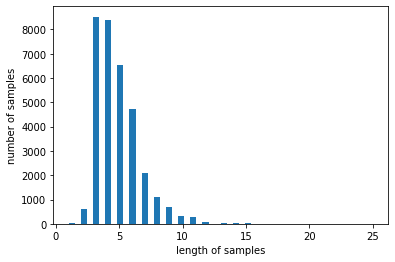

In [ ]:
print('문장 최대 길이 :',max(len(l) for l in terms))
print('문장 평균 길이 :',sum(map(len, terms))/len(terms))
plt.hist([len(s) for s in terms], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## word2vec

단어의 수가 적어서, min_count를 0으로 할당

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = terms, size = 50, window = 3, min_count = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(8707, 50)

In [ ]:
a = model.wv.most_similar("환경")
a

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('공공', 0.9518082737922668),
 ('대기', 0.9493098855018616),
 ('오염', 0.9474689960479736),
 ('군시설', 0.9456344246864319),
 ('유독', 0.9423642754554749),
 ('안전교육', 0.9409543871879578),
 ('영월군', 0.9408493638038635),
 ('재', 0.9403446912765503),
 ('유해', 0.94028240442276),
 ('공공시설', 0.9393013119697571)]

## 단어 벡터의 평균 구하기
terms에 할당된 데이터를 가지고, 단어 벡터를 할당하고, 평균값을 구해준다.

In [ ]:
def vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line: #수정함.
            if word in model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = model[word]
                else:
                    doc2vec = doc2vec +model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            
            document_embedding_list.append(doc2vec)
            
        else: # 
             print(doc2vec, line)
             break

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [ ]:
document_embedding_list = vectors(terms)
print('문서 벡터의 수 :',len(document_embedding_list))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


문서 벡터의 수 : 33543


In [ ]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (33543, 33543)


## 추천 (연관) 데이터 시스템 구현

In [ ]:
def recommendations(pre_title):
    books = df2[['pre_title', 'keyword']]

    # 검색어을 입력하면 해당 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df2.index, index = df2['pre_title']).drop_duplicates()    
    idx = indices[pre_title]

    # 입력된 데이터과 설명이 유사한 데이터 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:10]

    # 가장 유사한 데이터 10개의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 10개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    for i in recommend['pre_title']:
      print(i)

## 예시
파일명을 입력하면, 관련 10개 데이터를 추천해준다.

In [ ]:
recommendations("대기평균 측정데이터")

소음진동측정망 운영정보
울산광역시_대기 오염도 측정망 운영 현황
울산광역시_중금속측정현황
경상북도_구미시_환경소음도 현황
대기측정망
인천광역시 부평구_대기오염측정망 공개
부산광역시_지역별 대기오염 측정망 현황
토양측정망
경기도 대기오염 관련 현황


In [ ]:
recommendations("약수터 수질검사결과")

정수장 수질검사
지방하수도수질검사결과
부산광역시 남구 지하수수질검사결과
부산광역시_중구_수질 현황
물놀이 수질 검사 및 안전지역 정보
제주특별자치도_대기정보
기타 수질오염원 현황
서울특별시_한강 및 주요지천 수질 측정 자료
수도꼭지 수질검사결과(2014년3월)


In [ ]:
recommendations("행정안전부_도로명주소 기초구역도 전자지도")

행정안전부_도로명주소 기초구역도 전자지도
행정안전부_도로명 변경 현황자료
도로명주소 상세주소DB
도로명주소 건물DB_일간
도로명주소 주소DB_일간
도로명주소 사서함주소DB_분기
행정안전부_도로명주소 내비게이션용DB_월간
영문도로명주소DB(월간)
도로명주소 전자지도(월간)
